<a href="https://colab.research.google.com/github/Jaiharish-passion07/Facial_emotion_capstone_project_final/blob/master/Captain_Face_Emotion_Recognition_Ashik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Introduction**

*   The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms
*   Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms
*   One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge
*   In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention




 


# **Problem Statements**


*   Digital classrooms are conducted via video telephony software program (ex-
Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance
*   While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts.which can be analysed using deep learning algorithms
*  Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked

To solve this above problem and challenges. We have a solution to rectify those issues with help of **Deep Learning Algorithms** using Convolution Neural Networks.It is **Facial Emotions Recognition Application**

#<u>Importing all Necessary Libraries</u>

In [6]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')


#Importing Libraires required for CNN models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau,Callback
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Flatten,Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D, SeparableConv2D,Input, GlobalAveragePooling2D,concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report,roc_curve, roc_auc_score,confusion_matrix
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Facial_Emotion_capstone_project/archive.zip" -d "/content/face/"

Archive:  /content/drive/MyDrive/Facial_Emotion_capstone_project/archive.zip
  inflating: /content/face/fer2013.csv  


#<u>Loading Datasets</u>

In [7]:
#Reading data
df=pd.read_csv("/content/face/fer2013.csv")

In [8]:
#print first five rows
df.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [9]:
#shape of the dataset
df.shape

(35887, 3)

In [10]:
#checking for null values
df.isnull().sum()


emotion    0
pixels     0
Usage      0
dtype: int64

In [11]:
#emotion class
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [12]:
#lable of different emotion
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

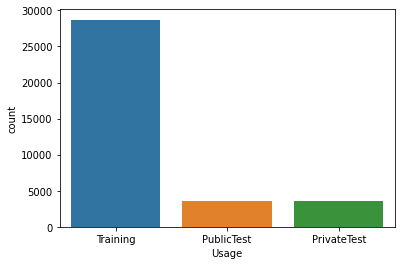

In [13]:
# Let's plot the count of each set
sns.countplot(df.Usage)
plt.show()

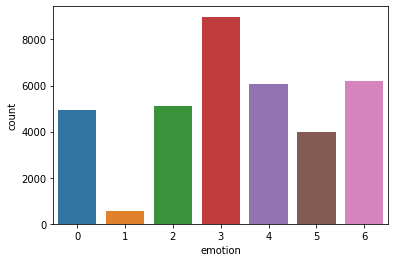

In [14]:
#plot for value count
sns.countplot(df.emotion)
plt.show()

Our dataset have 7 types of emotion ranging form 0-6:

0.   Anger
1.   Disgust
2.   Fear
3.   Happiness
4.   Sad
5.   Surprise
6.   Neutral

After looking bar plot we can observe that majority of the classes belongs to 3:Happy, 4:Sad and 6:Neutral on the otherside 0:anger, 2: Sad and 5:surprise are avarage and 1:disgust is very low in number 

#<u>Display Images</u>

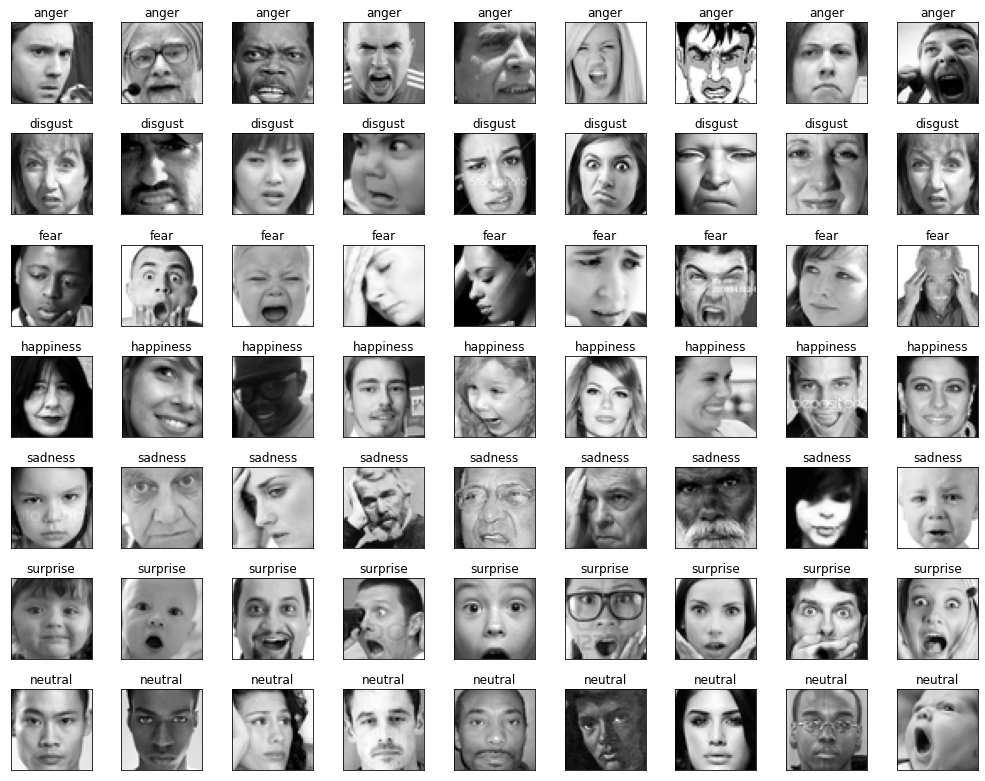

In [15]:
# size of the image: 48*48 pixels

fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(9):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(9, 9, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

Now prepare data for campatible for neural network

#<u>Defining Parameters</u>

In [16]:
# Defining the parameters
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

#<u>Preprocessing the Data</u>

In [17]:
#Image preprocessing
df['pixels']=df['pixels'].astype("string")
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(df['emotion']).to_numpy()

#<u>Split Data into Training, Validation and Testing </u>

In [18]:
#Dataset split for training model 
X_train, X_valid, y_train, y_valid = train_test_split(faces,emotions,
                                                    shuffle=True,
                                                    test_size=0.2, random_state=42)
X_valid,X_test,y_valid,y_test=train_test_split(faces,emotions,test_size=0.2,shuffle=True)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape,X_test.shape,y_test.shape

((28709, 48, 48, 1),
 (28709, 48, 48, 1),
 (28709, 7),
 (28709, 7),
 (7178, 48, 48, 1),
 (7178, 7))

In [19]:
#variable allocation
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

#<u>Performing Data Augmentation</u>

In [20]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,         # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.15,    # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,   # randomly shift images vertically (fraction of total height)
    shear_range=0.15,
    zoom_range=0.15,           # randomly zoom into images
    horizontal_flip=True,      # randomly flip images
)
train_datagen.fit(X_train)

#<u>Model Initialization</u>

### **1-Mobilenet:**

In [21]:
MobileNet = MobileNet(input_shape=[48,48]+ [1], weights=None, include_top=True,classes=7)

In [22]:
mobile_model = Model(inputs=MobileNet.input, outputs=MobileNet.output)

In [23]:
optim =optimizers.Adam(learning_rate=0.01) 
mobile_model.compile(optimizer=optim,loss='categorical_crossentropy', metrics=['accuracy'])

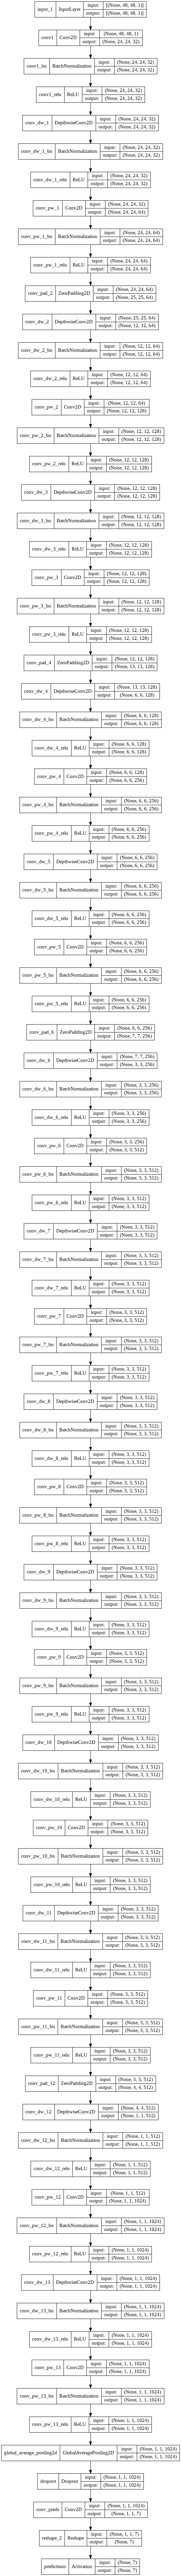

In [24]:
#plot for architechture
plot_model(mobile_model, to_file='mobile_net.png', show_shapes=True, show_layer_names=True)

In [25]:
#model compilation
mobile_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        288       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                                      

### **2-Dexpression:**

In [26]:
#function for taking input for the layer
def dexpression():
    inputs = Input(shape=(shape_x, shape_y, 1))

    x = Conv2D(64, 7, strides = 2, padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x_1 = Conv2D(96, 1, strides = 1, padding='same')(x)
    x_1 = Activation('relu')(x_1)
    x_1 = MaxPooling2D(3, strides=1, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)

    x_2 = Conv2D(208, 3, strides = 1, padding='same')(x_1)
    x_2 = Activation('relu')(x_2)
    x_2 = MaxPooling2D(3, strides=1, padding='same')(x_2)

    x_3 = Conv2D(64, 1, strides = 1, padding='same')(x_1)
    x_3 = Activation('relu')(x_3)
    x_3 = MaxPooling2D(3, strides=1, padding='same')(x_3)


    x_4=concatenate([x_2,x_3],axis=3)

    x_5 = Conv2D(96, 1, strides = 1, padding='same')(x_4)
    x_5 = Activation('relu')(x_5)
    x_5 = Conv2D(208, 3, strides = 1, padding='same')(x_5)
    x_5 = Activation('relu')(x_5)

    x_6 = MaxPooling2D(3, strides=1, padding='same')(x_4)
    x_6 = Activation('relu')(x_6)
    x_6 = Conv2D(64, 1, strides = 1, padding='same')(x_6)
    x_6 = Activation('relu')(x_6)
    x_6 = MaxPooling2D(3, strides=1, padding='same')(x_6)
    x_7 = concatenate([x_5,x_6],axis=3)

    x_8 = Flatten()(x_7)
    x_8 = Dropout(0.25)(x_8)
    x_8 = Dense(7, activation='softmax')(x_8)
    return Model(inputs, x_8,name='DeXpression')

In [27]:
#model name 
dexpression=dexpression()

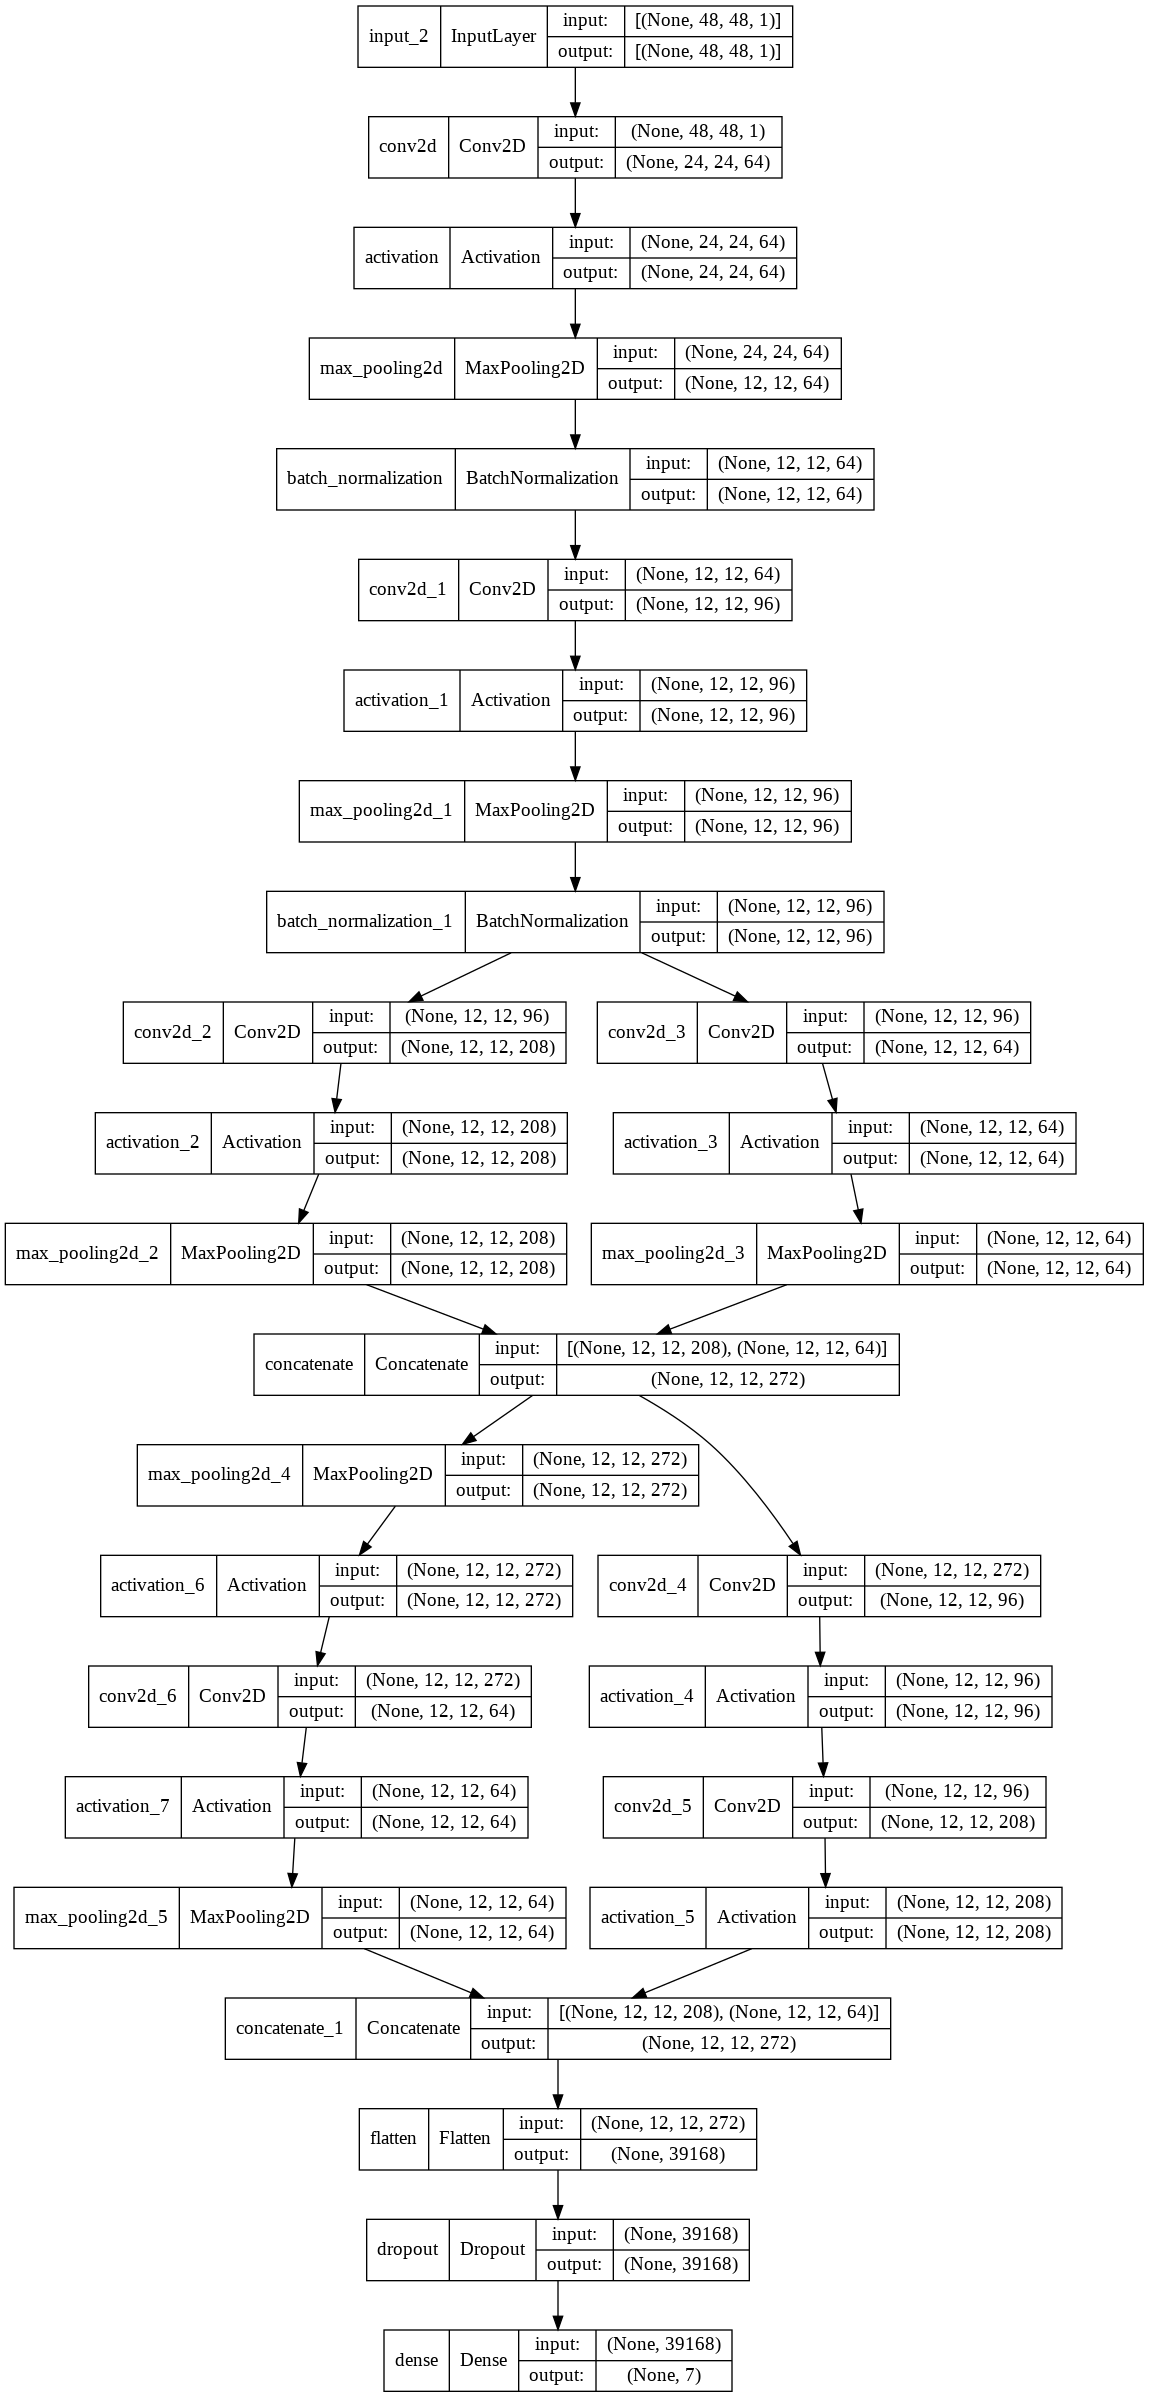

In [28]:
#plot for architechture
plot_model(dexpression, to_file='despression.png', show_shapes=True, show_layer_names=True)

In [29]:
#model compilation
dexpression.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dexpression.summary()

Model: "DeXpression"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 24, 24, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 12, 64)   0           ['activation[0][0]']             
                                                                                        

### **3: CNN :**

In [30]:
# Building up Model Architecture
def CNN():
    model = Sequential()

    #1st CNN layer
    model.add(Conv2D(64,(3,3),padding = 'same', name='image_array', input_shape = (48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    #2nd CNN layer
    model.add(Conv2D(128,(5,5),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #3rd CNN layer
    model.add(Conv2D(512,(3,3),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #4th CNN layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Fully connected 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [31]:
#model name
CNN=CNN()

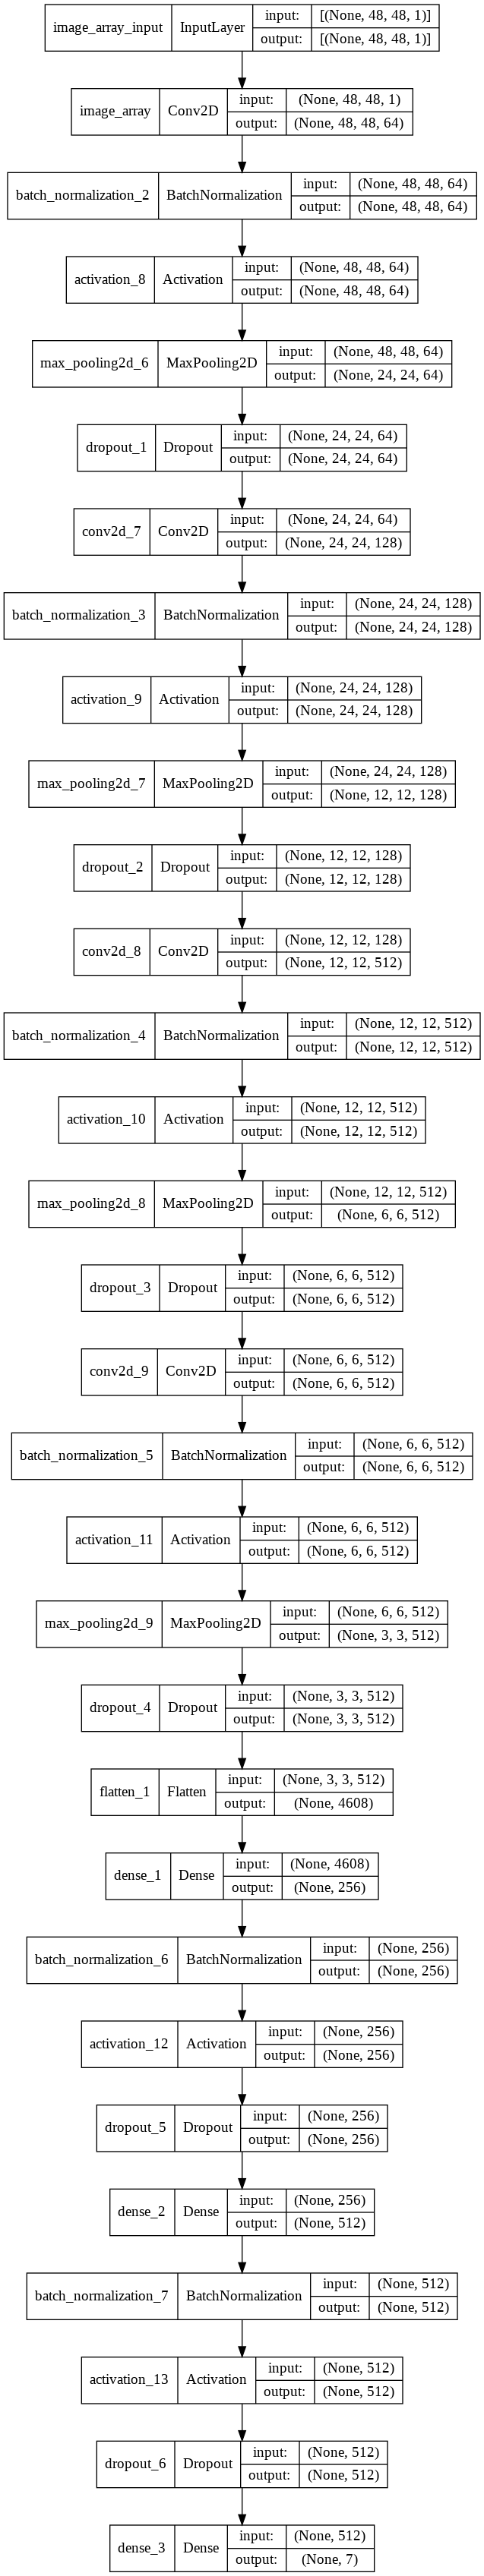

In [32]:
# Plotting architecture of defined model
plot_model(CNN, to_file='CNN.png', show_shapes=True, show_layer_names=True)

In [33]:
# Compiling the model
opt = optimizers.Adam(learning_rate=0.001) #using Adam Optimizer
CNN.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
CNN.summary() #gives the information about the architecture and configuration of the neural network.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       2

### **4: Densenet :**


In [34]:
DenseNet121 = DenseNet121(input_shape=[48,48]+ [1], weights=None, include_top=True,classes=7)
dense_net_model = Model(inputs=DenseNet121.input, outputs=DenseNet121.output)
dense_opt= optimizers.Adam(learning_rate=0.01) #using Adam Optimizer
dense_net_model.compile(optimizer=dense_opt,loss='categorical_crossentropy', metrics=['accuracy'])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690719 to fit



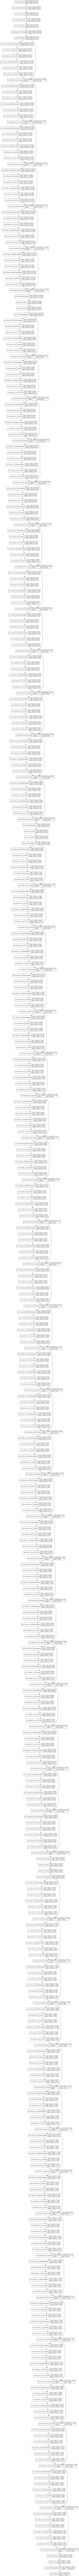

In [35]:
# Plotting architecture of defined model
plot_model(dense_net_model, to_file='dense_net_model.png', show_shapes=True, show_layer_names=True)

### **5: Resnet :**


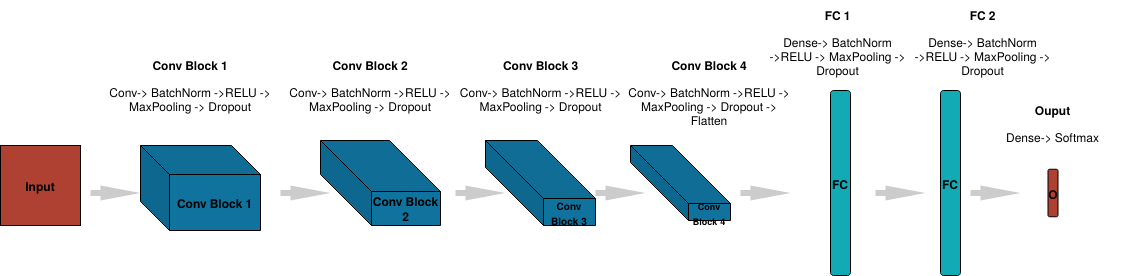

In [36]:
#Function for building the Residual network 
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used 'ELU' as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. 'he_normal' kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

#<u>Training the Models</u>#


### **1.Mobilenet:**

In [37]:
#parameters for training the model
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=50, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'mobilenet'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [38]:
#model history for further evaluation the performance
mobile_history =mobile_model.fit(train_datagen.flow(X_train, y_train, batch_size),
          steps_per_epoch=len(X_train) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(X_valid,y_valid))

Epoch 1/50
896/897 [============================>.] - ETA: 0s - loss: 1.9612 - accuracy: 0.2454
Epoch 00001: val_loss improved from inf to 1.77768, saving model to models/mobilenet.01-0.27.hdf5
897/897 [==============================] - 42s 33ms/step - loss: 1.9611 - accuracy: 0.2454 - val_loss: 1.7777 - val_accuracy: 0.2725 - lr: 0.0100
Epoch 2/50
898/897 [==============================] - ETA: 0s - loss: 1.7525 - accuracy: 0.2826
Epoch 00002: val_loss did not improve from 1.77768
897/897 [==============================] - 28s 32ms/step - loss: 1.7525 - accuracy: 0.2826 - val_loss: 1.7841 - val_accuracy: 0.2923 - lr: 0.0100
Epoch 3/50
897/897 [============================>.] - ETA: 0s - loss: 1.7050 - accuracy: 0.3072
Epoch 00003: val_loss did not improve from 1.77768
897/897 [==============================] - 29s 32ms/step - loss: 1.7050 - accuracy: 0.3072 - val_loss: 1.9044 - val_accuracy: 0.2914 - lr: 0.0100
Epoch 4/50
897/897 [============================>.] - ETA: 0s - loss: 1.64

In [39]:
#save model for the future use  
mobile_model.save('finalmobilenet_model.h5')

### **2.Dexpression:**

In [40]:
#model parameter for taining the model
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + '_DeXpression'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [41]:
#model history for the matrics evaluation
dexpression_history =dexpression.fit(train_datagen.flow(X_train, y_train, batch_size),
          steps_per_epoch=len(X_train) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(X_valid,y_valid))

Epoch 1/50
898/897 [==============================] - ETA: 0s - loss: 1.8119 - accuracy: 0.2656
Epoch 00001: val_loss improved from inf to 1.72805, saving model to models/_DeXpression.01-0.30.hdf5
897/897 [==============================] - 21s 22ms/step - loss: 1.8119 - accuracy: 0.2656 - val_loss: 1.7280 - val_accuracy: 0.3034 - lr: 0.0010
Epoch 2/50
896/897 [============================>.] - ETA: 0s - loss: 1.7012 - accuracy: 0.3121
Epoch 00002: val_loss improved from 1.72805 to 1.60172, saving model to models/_DeXpression.02-0.36.hdf5
897/897 [==============================] - 22s 24ms/step - loss: 1.7010 - accuracy: 0.3123 - val_loss: 1.6017 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 3/50
897/897 [============================>.] - ETA: 0s - loss: 1.6043 - accuracy: 0.3610
Epoch 00003: val_loss improved from 1.60172 to 1.50780, saving model to models/_DeXpression.03-0.41.hdf5
897/897 [==============================] - 20s 22ms/step - loss: 1.6048 - accuracy: 0.3610 - val_loss: 1.5078

In [42]:
#save model for further use
dexpression.save('finaldexpression_model.h5')

### **3.CNN:**

In [43]:
#model parameter for taining the model
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'cnn'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [44]:
#model history for the matrics evaluation
CNN_history =CNN.fit(train_datagen.flow(X_train, y_train, batch_size),
          steps_per_epoch=len(X_train) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(X_valid,y_valid))

Epoch 1/50
897/897 [============================>.] - ETA: 0s - loss: 1.8745 - accuracy: 0.2517
Epoch 00001: val_loss improved from inf to 1.79247, saving model to models/cnn.01-0.33.hdf5
897/897 [==============================] - 27s 28ms/step - loss: 1.8741 - accuracy: 0.2519 - val_loss: 1.7925 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 2/50
896/897 [============================>.] - ETA: 0s - loss: 1.5975 - accuracy: 0.3747
Epoch 00002: val_loss improved from 1.79247 to 1.46071, saving model to models/cnn.02-0.42.hdf5
897/897 [==============================] - 25s 28ms/step - loss: 1.5974 - accuracy: 0.3749 - val_loss: 1.4607 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 3/50
897/897 [============================>.] - ETA: 0s - loss: 1.4452 - accuracy: 0.4423
Epoch 00003: val_loss improved from 1.46071 to 1.39218, saving model to models/cnn.03-0.47.hdf5
897/897 [==============================] - 25s 28ms/step - loss: 1.4451 - accuracy: 0.4424 - val_loss: 1.3922 - val_accuracy: 0.4732 - l

In [45]:
# Save best Model
CNN.save('finalcnn_model.h5')

### **4.Densenet:**

In [46]:
#model parameter for taining the model
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'densenet'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [47]:
#model history for the matrics evaluation
dense_net_history =dense_net_model.fit(train_datagen.flow(X_train, y_train, batch_size),
          steps_per_epoch=len(X_train) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(X_valid,y_valid))

Epoch 1/50
898/897 [==============================] - ETA: 0s - loss: 1.9941 - accuracy: 0.2406
Epoch 00001: val_loss improved from inf to 1.83085, saving model to models/densenet.01-0.21.hdf5
897/897 [==============================] - 113s 112ms/step - loss: 1.9941 - accuracy: 0.2406 - val_loss: 1.8308 - val_accuracy: 0.2057 - lr: 0.0100
Epoch 2/50
898/897 [==============================] - ETA: 0s - loss: 1.7703 - accuracy: 0.2675
Epoch 00002: val_loss improved from 1.83085 to 1.73912, saving model to models/densenet.02-0.28.hdf5
897/897 [==============================] - 97s 109ms/step - loss: 1.7703 - accuracy: 0.2675 - val_loss: 1.7391 - val_accuracy: 0.2838 - lr: 0.0100
Epoch 3/50
898/897 [==============================] - ETA: 0s - loss: 1.7116 - accuracy: 0.3007
Epoch 00003: val_loss improved from 1.73912 to 1.68538, saving model to models/densenet.03-0.32.hdf5
897/897 [==============================] - 97s 109ms/step - loss: 1.7116 - accuracy: 0.3007 - val_loss: 1.6854 - val_a

In [48]:
# Save best Model
dense_net_model.save('final_densenet.h5')

### **5.Resnet:**

In [ ]:
"""
I used two callbacks one is 'early stopping' for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

In [ ]:
# Tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
resnet_model = build_net(optims[1]) 

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [ ]:
resnet_history = resnet_model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=num_epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

In [ ]:
# Save best Model
resnet_model.save('final_model.h5')

#<u>Plotting Accuracy and Loss curves</u>


In [ ]:
mobile_history,dexpression_history,CNN_history,dense_net_history,resnet_history

(<keras.callbacks.History at 0x7fd28f830610>,
 <keras.callbacks.History at 0x7fd21542f7d0>)

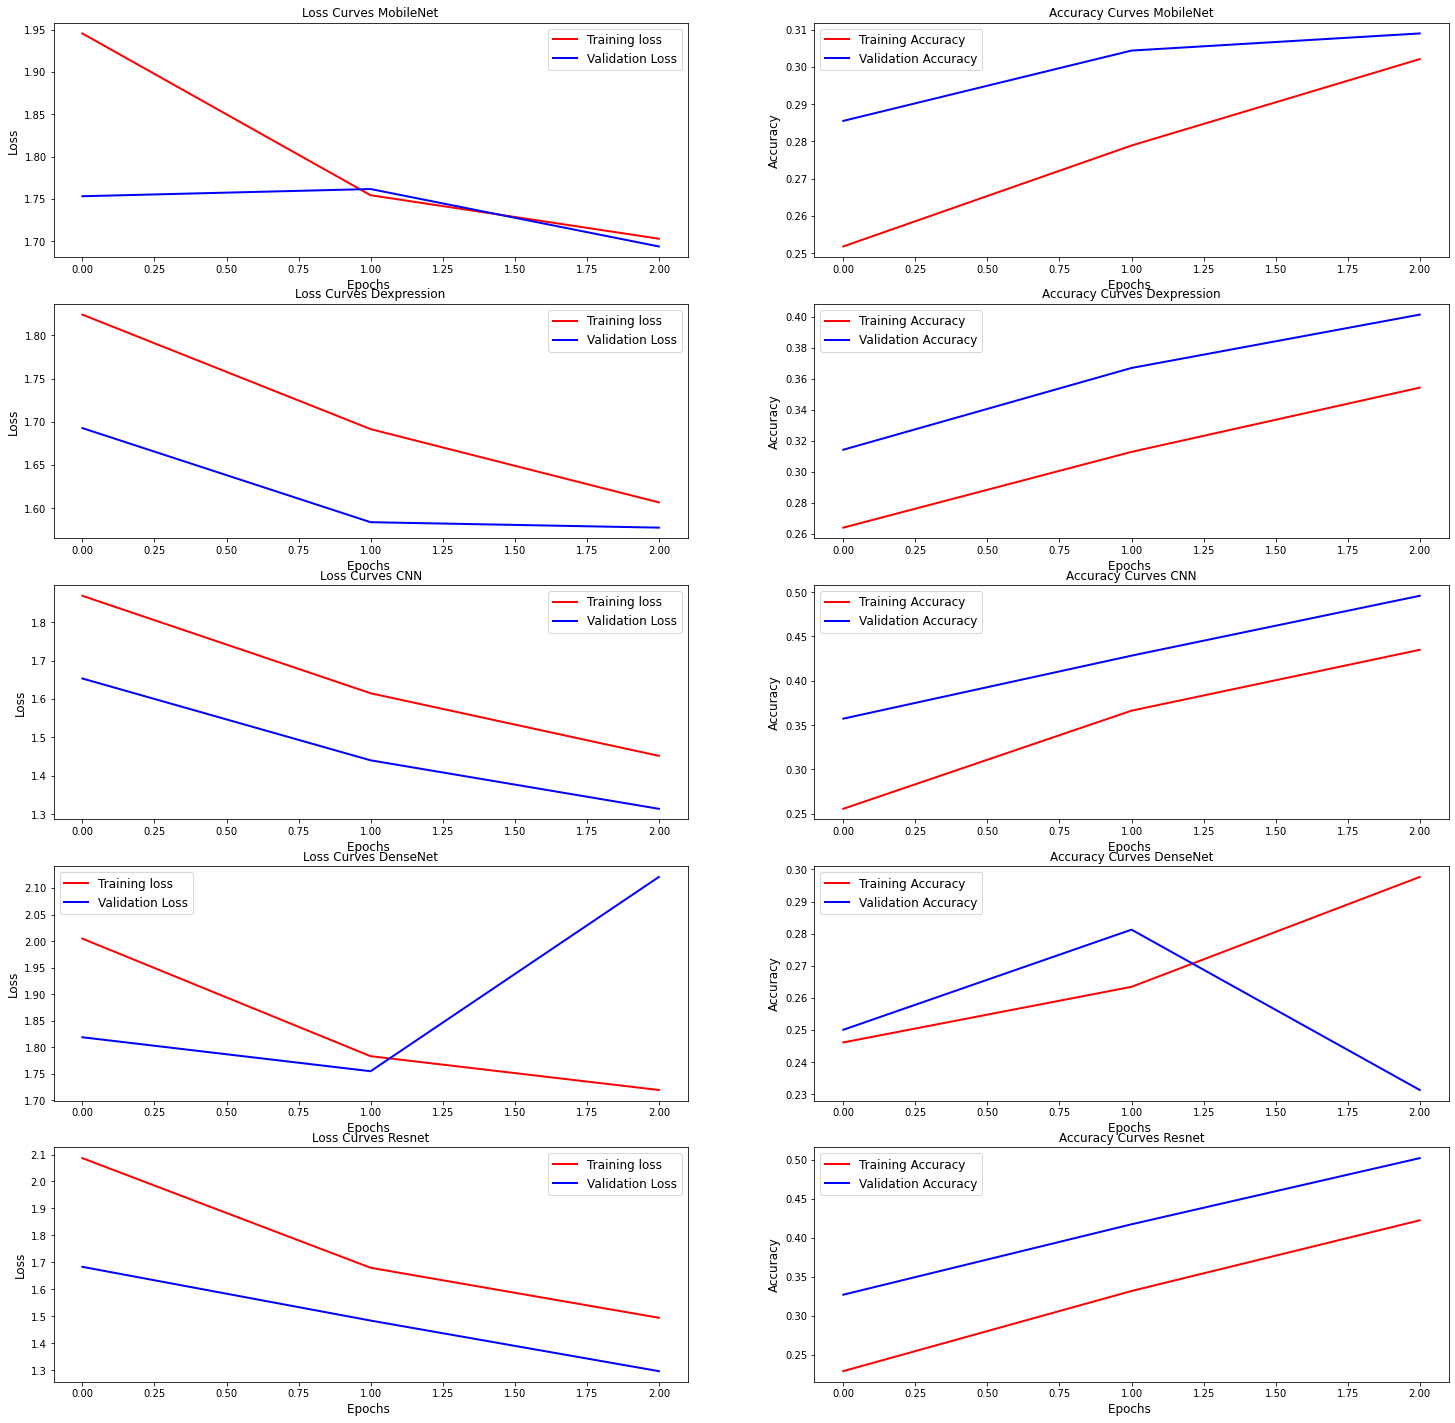

In [ ]:
#Plotting accuaracy and loss curves for all models
fig,axes=plt.subplots(5,2,figsize=(25, 25))

for (m,history), ax in zip({'MobileNet':mobile_history,'Dexpression':dexpression_history,'CNN':CNN_history,'DenseNet':dense_net_history,'Resnet':resnet_history}.items(),axes):
  # Loss Curves
  ax[0].plot(history.history['loss'],'r',linewidth=2.0)
  ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
  ax[0].legend(['Training loss', 'Validation Loss'],fontsize=12)
  ax[0].set_xlabel('Epochs ',fontsize=12)
  ax[0].set_ylabel('Loss',fontsize=12)
  ax[0].set_title('Loss Curves '+m,fontsize=12)

  # Accuracy Curves
  ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
  ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
  ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
  ax[1].set_xlabel('Epochs ',fontsize=12)
  ax[1].set_ylabel('Accuracy',fontsize=12)
  ax[1].set_title('Accuracy Curves '+m,fontsize=12)



In [ ]:
#save the accuracy /loss plot
plt.savefig('plots.png')

<Figure size 432x288 with 0 Axes>

#<u>Classification Reports</u>


In [ ]:
model_name=['MobileNet','Dexpression','Custom CNN','DenseNet','Resnet']
iter_=0

In [ ]:
#Classification Reports for all model
for model in [mobile_model,dexpression,CNN,dense_net_model,resnet_model]:
    ypred=model.predict(X_test)
    ypred_=np.argmax(ypred, axis=1)
    ytest_=np.argmax(y_test, axis=1)
    print("-------"+model_name[iter_]+"-------")
    print("\n")
    print(classification_report(ytest_, ypred_,digits=3))
    iter_=iter_+1

-------MobileNet-------


              precision    recall  f1-score   support

           0      0.294     0.005     0.010       973
           1      0.000     0.000     0.000       112
           2      0.163     0.171     0.167      1043
           3      0.521     0.511     0.516      1776
           4      0.283     0.190     0.228      1229
           5      0.251     0.772     0.379       784
           6      0.216     0.188     0.201      1261

    accuracy                          0.302      7178
   macro avg      0.247     0.262     0.214      7178
weighted avg      0.306     0.302     0.269      7178

-------Dexpression-------


              precision    recall  f1-score   support

           0      0.286     0.057     0.094       973
           1      0.000     0.000     0.000       112
           2      0.254     0.303     0.276      1043
           3      0.456     0.782     0.576      1776
           4      0.301     0.211     0.248      1229
           5      0.576 

#<u>Plotting Confusion Matrix</u>


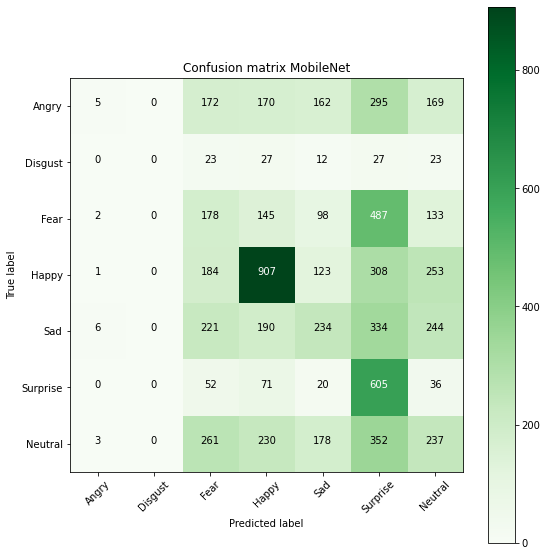

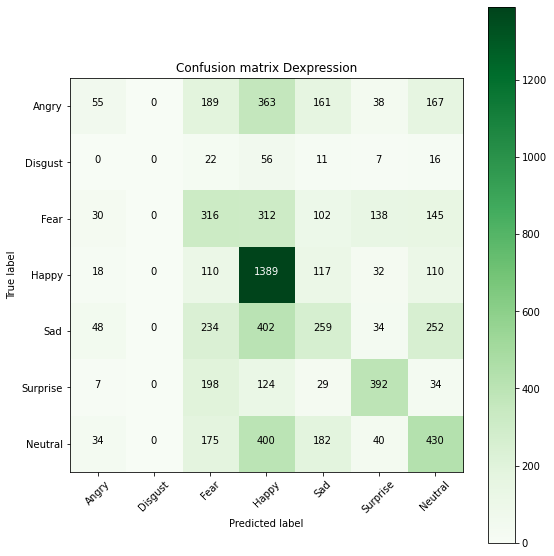

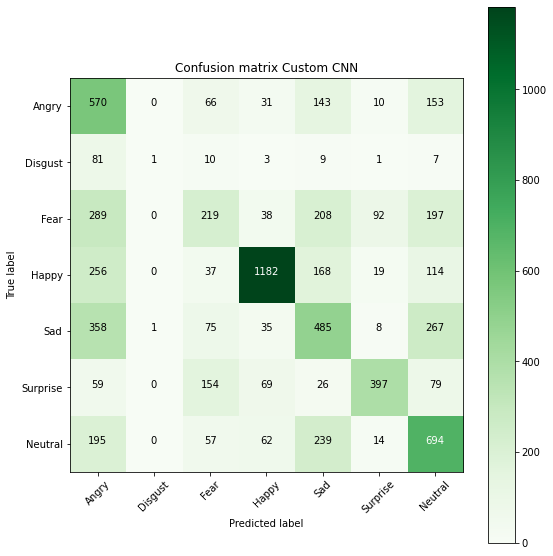

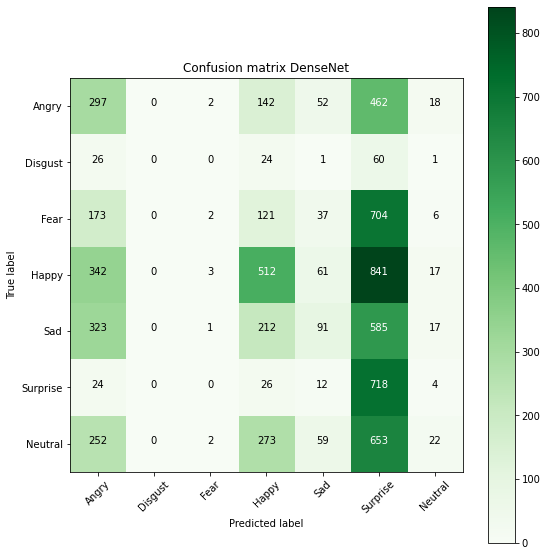

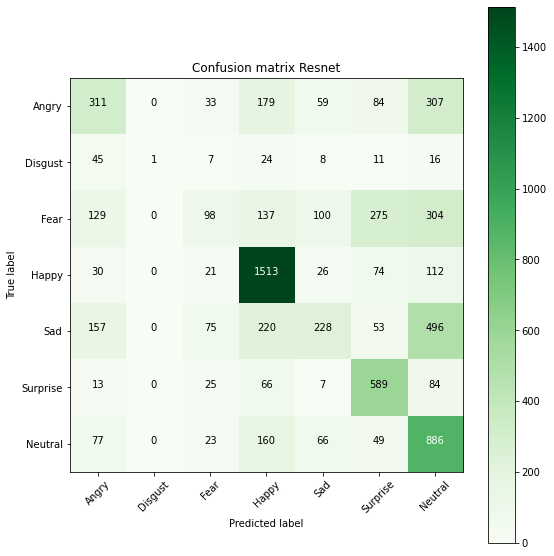

In [ ]:
#plot confusion matrix
import itertools
for model,i in zip([mobile_model,dexpression,CNN,dense_net_model,resnet_model],[1,2,3,4,5]):
    fig = plt.figure(figsize=(8, 8))
    
    ypred=model.predict(X_test)
    rounded_predections=np.argmax(ypred, axis=1)
    rounded_labels=np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, rounded_predections)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix '+model_name[i-1]
    

    plt.imshow(cm, interpolation='nearest',cmap='Greens')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_'+model.name+'.png')
    plt.show()

#<u>Testing the Model using Real Time webcam in Google Colab Notebook</u>

In [ ]:
# Import Libaraires 

from IPython.display import display, Javascript, Image,clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# Defining function to detect face
def face_detect():
  import cv2
  from PIL import Image
  import numpy as np
  import os
  from keras.models import load_model
  from time import sleep
  from keras.preprocessing.image import img_to_array
  from keras.preprocessing import image
# start streaming video from webcam
  video_stream()
# label for video
  label_html = 'Capturing...'
# initialze bounding box to empty
  bbox = ''
  count = 0
  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # Face Detection
  classifier =load_model('/content/final_model.h5')  #Load model
  emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise'] 

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
      roi_gray = gray[y:y+h,x:x+w]
      roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction
      if np.sum([roi_gray])!=0:
        roi = roi_gray.astype('float')/255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction
        prediction = classifier.predict(roi)[0]   #Prediction
        label=emotion_labels[prediction.argmax()]
        label_position = (x,y)
        cv2.putText(bbox_array,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)   # Text Adding
      else:
        cv2.putText(bbox_array,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

In [ ]:
# Finally detecting the face with live webcam
#face_detect()

# **Conclusion:**
The data preprocessing takes time for processing each image.

Deepface, CNN, dexpression, ResNet, and Xception were among the models evaluated. 

ResNet has the highest accuracy of all, with a validation set accuracy of 72 percent and a training set accuracy of 66 percent.


Since, the emotion counts of disgust and fear images are less therefore on local webcam it hardly detect those emotions.

The codes which are deployed are on my github repository.

It was such an amazing and interesting project. Learnt a lot from this.